In [31]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.35"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp


import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 
import ml_collections

from orbax.checkpoint import (
    Checkpointer,
    CheckpointManager,
    JsonCheckpointHandler,
    PyTreeCheckpointHandler,
)

from clu import parameter_overview
from clu import deterministic_data
from pathlib import Path

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations.affine import gen_affine_matrix_no_shear, transform_image_with_affine_matrix
from src.transformations import transform_image
from experiments.configs.pgm_mnist import get_config
from src.utils.input import get_data
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.models.transformation_generative_model import TransformationGenerativeNet, make_transformation_generative_train_and_eval, create_transformation_generative_state
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## matplotlib preamble

In [2]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7


In [3]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
matplotlib.rc('font', **{'family': 'serif'})

# Turn on if you've got TeX installed
# matplotlib.rc('text', usetex=True)

# plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})


In [4]:
rng = random.PRNGKey(0)

# Figures

In [5]:
def get_config_state(checkpoint_dir):
    handlers = {
    "state": Checkpointer(PyTreeCheckpointHandler()),
    "config": Checkpointer(JsonCheckpointHandler()),
    }
    manager = CheckpointManager(
        Path(checkpoint_dir) / "checkpoints", checkpointers=handlers
    )
    last_type_step = manager.latest_step()
    ckpt_restored = manager.restore(last_type_step)

    config = ckpt_restored["config"]
    config = ml_collections.ConfigDict(config)
    state = ckpt_restored["state"]
    return config, state


## DSPRITES figures

In [6]:
# Prototype model run:
# https://wandb.ai/invariance-learners/iclr2024experiments/runs/1y0ddd88 
# prototype_model_dir = "/home/brunokm/projects/learning-invariances/outputs/2023-10-17/00-29-25"

# https://wandb.ai/invariance-learners/iclr2024experiments/runs/7m0ph6jd/overview?workspace=user-brunokm
prototype_model_dir= "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-31-39"

# Load the prototype model
proto_config, proto_state = get_config_state(prototype_model_dir)
proto_model = TransformationInferenceNet(
    bounds=proto_config.get("augment_bounds", None),
    offset=proto_config.get("augment_offset", None),
    **proto_config.model.inference
)

def prototype_transform_function(x, rng):
    η = proto_model.apply({"params": proto_state["params"]}, x, train=False).sample(
        seed=rng
    )
    return η

def prototype_function(x, rng):
    η = prototype_transform_function(x, rng)
    η_aff_mat = gen_affine_matrix_no_shear(η)
    η_aff_mat_inv = jnp.linalg.inv(η_aff_mat)
    xhat = transform_image_with_affine_matrix(x, η_aff_mat_inv, order=proto_config.interpolation_order)
    return xhat, η

INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-31-39/checkpoints/40001/state.


INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-31-39/checkpoints/40001/state.
INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-31-39/checkpoints/40001/config.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-31-39/checkpoints/40001/config.


In [7]:
# Generative model run:
# https://wandb.ai/invariance-learners/iclr2024experiments/runs/n6iq6hcy
gen_model_dir = "/home/brunokm/projects/learning-invariances/outputs/2023-10-17/08-45-17"

# Load the generative model

gen_config, gen_state = get_config_state(gen_model_dir)
gen_model = TransformationGenerativeNet(
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
    **gen_config.model.generative
)
p,_  = gen_model.apply({"params": gen_state["params"]}, jnp.zeros((64, 64, 1)),η =jnp.zeros((5,)), train=False)


assert gen_config.prototype_model_dir == prototype_model_dir
def gen_function(x, rng):
    xhat, _ = prototype_function(x, rng)
    p_H_xhat, _ = gen_model.apply({"params": gen_state["params"]}, xhat, η=jnp.zeros((5,)), train=False)
    return p_H_xhat

INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-17/08-45-17/checkpoints/60001/state.


INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-17/08-45-17/checkpoints/60001/state.
INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-17/08-45-17/checkpoints/60001/config.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-17/08-45-17/checkpoints/60001/config.


In [12]:
# Get each of: heart, ellipse, square:
rng, data_rng = random.split(rng)
_, val_ds, _ = get_data(proto_config, data_rng)
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)
hearts_batch = jax.tree_map(lambda x: x[val_batch["label"] == 0], val_batch)
ellipses_batch = jax.tree_map(lambda x: x[val_batch["label"] == 1], val_batch)
squares_batch = jax.tree_map(lambda x: x[val_batch["label"] == 2], val_batch)

INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[64, 64, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing:

#### Get the prototype reconstructions plots:

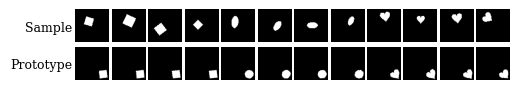

In [9]:
num_images_per_shape = 4
fig = plt.figure(figsize=(text_width, 2 * text_width / (3 * num_images_per_shape)))
axes = fig.subplots(nrows=2, ncols= 3 * num_images_per_shape, squeeze=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

images = [
    shape_batch["image"][i]
    for shape_batch in [hearts_batch, ellipses_batch, squares_batch]
    for i in range(num_images_per_shape)
]
for i, image in enumerate(images):
    axes[0, i].imshow(image, cmap="gray", vmin=-1.0, vmax=1.0)
    axes[0, i].axis("off")
    axes[1, i].imshow(prototype_function(image, rng)[0], cmap="gray", vmin=-1.0, vmax=1.0)
    axes[1, i].axis("off")
axes[0, 0].set_title('Sample', y=0.0, x=-0.1, horizontalalignment="right", verticalalignment="bottom")
axes[1, 0].set_title('Prototype', y=0.0, x=-0.1, horizontalalignment="right", verticalalignment="bottom")

fig.savefig("figures/dsprites_prototype_reconstruction.pdf", bbox_inches="tight")


### Get the "heatmap" of resampled and the train data

In [10]:
def put_images_in_grid(
    images,
    grid_size: int,
):
    out = jnp.zeros(
        (grid_size * images.shape[1], grid_size * images.shape[2], *images.shape[3:]),
        dtype=images.dtype,
    )
    for i in range(grid_size):
        for j in range(grid_size):
            out = out.at[
                i * images.shape[1] : (i + 1) * images.shape[1],
                j * images.shape[2] : (j + 1) * images.shape[2],
            ].set(images[i * grid_size + j])
    return out



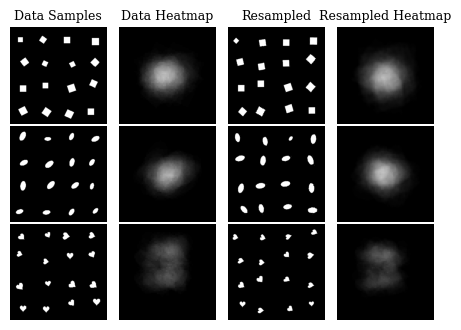

In [13]:
n_images=100
grid_size = 4
assert grid_size ** 2 <= n_images


def resample_image(x, rng):
    rng1, rng2, rng3 = random.split(rng, 3)
    xhat = prototype_function(x, rng1)[0]
    p_H = gen_function(x, rng2)
    η_resampled = p_H.sample(seed=rng3)
    return transform_image_with_affine_matrix(
        xhat, gen_affine_matrix_no_shear(η_resampled), order=proto_config.interpolation_order,
    )

fig = plt.figure(figsize=(text_width, 1 + 3 * text_width / (6)))
axes = fig.subplots(nrows=3, ncols= 4, squeeze=True)
fig.subplots_adjust(wspace=0.02, hspace=0.02)
for i in range(3):
    # n_images_in_ax = 0
    shape_batch = jax.tree_map(lambda x: x[val_batch["label"] == i], val_batch)
    if len(shape_batch["image"]) < n_images:
        raise
    imgs = shape_batch["image"][:n_images]
    img_agg = (jnp.mean(imgs, axis=0) + 1) / 2.0
    resampled_imgs = jax.vmap(resample_image, in_axes=(0, 0))(imgs, random.split(rng, n_images))
    resampled_img_agg = (jnp.mean(resampled_imgs, axis=0) + 1) / 2.0
    axes[i, 1].imshow(img_agg, cmap="gray", vmin=0.0, vmax=1.0)
    axes[i, 3].imshow(resampled_img_agg, cmap="gray", vmin=0.0, vmax=1.0)

    imgs_grid = put_images_in_grid(imgs[:grid_size**2], grid_size)
    resampled_imgs_grid = put_images_in_grid(resampled_imgs[:grid_size**2], grid_size)

    axes[i, 0].imshow(imgs_grid, cmap="gray", vmin=-1.0, vmax=1.0)
    axes[i, 2].imshow(resampled_imgs_grid, cmap="gray", vmin=-1.0, vmax=1.0)

    axes[i, 0].axis("off")
    axes[i, 1].axis("off")
    axes[i, 2].axis("off")
    axes[i, 3].axis("off")
# axes[0, 0].set_title('Original', y=0.0, x=-0.1, horizontalalignment="right", verticalalignment="bottom")
axes[0, 0].set_title('Data Samples')
axes[0, 1].set_title('Data Heatmap')
axes[0, 2].set_title('Resampled')
axes[0, 3].set_title('Resampled Heatmap')

axes[0, 0].set_ylabel('Squares')
axes[1, 0].set_ylabel('Ellipses')
axes[2, 0].set_ylabel('Hearts')
    # if n_images_in_ax < n_images:
    #     raise
        # val_batch = next(val_iter)
        # shape_batch = jax.tree_map(lambda x: x[val_batch["label"] == i], val_batch)


    # axes[0, i].imshow(hearts_batch["image"][i], cmap="gray", vmin=-1.0, vmax=1.0)
fig.savefig("figures/dsprites_resamped_aug_plot.pdf", bbox_inches="tight")

### Get the ``cross-sections'' of the transformation parameter distribution for different shapes:

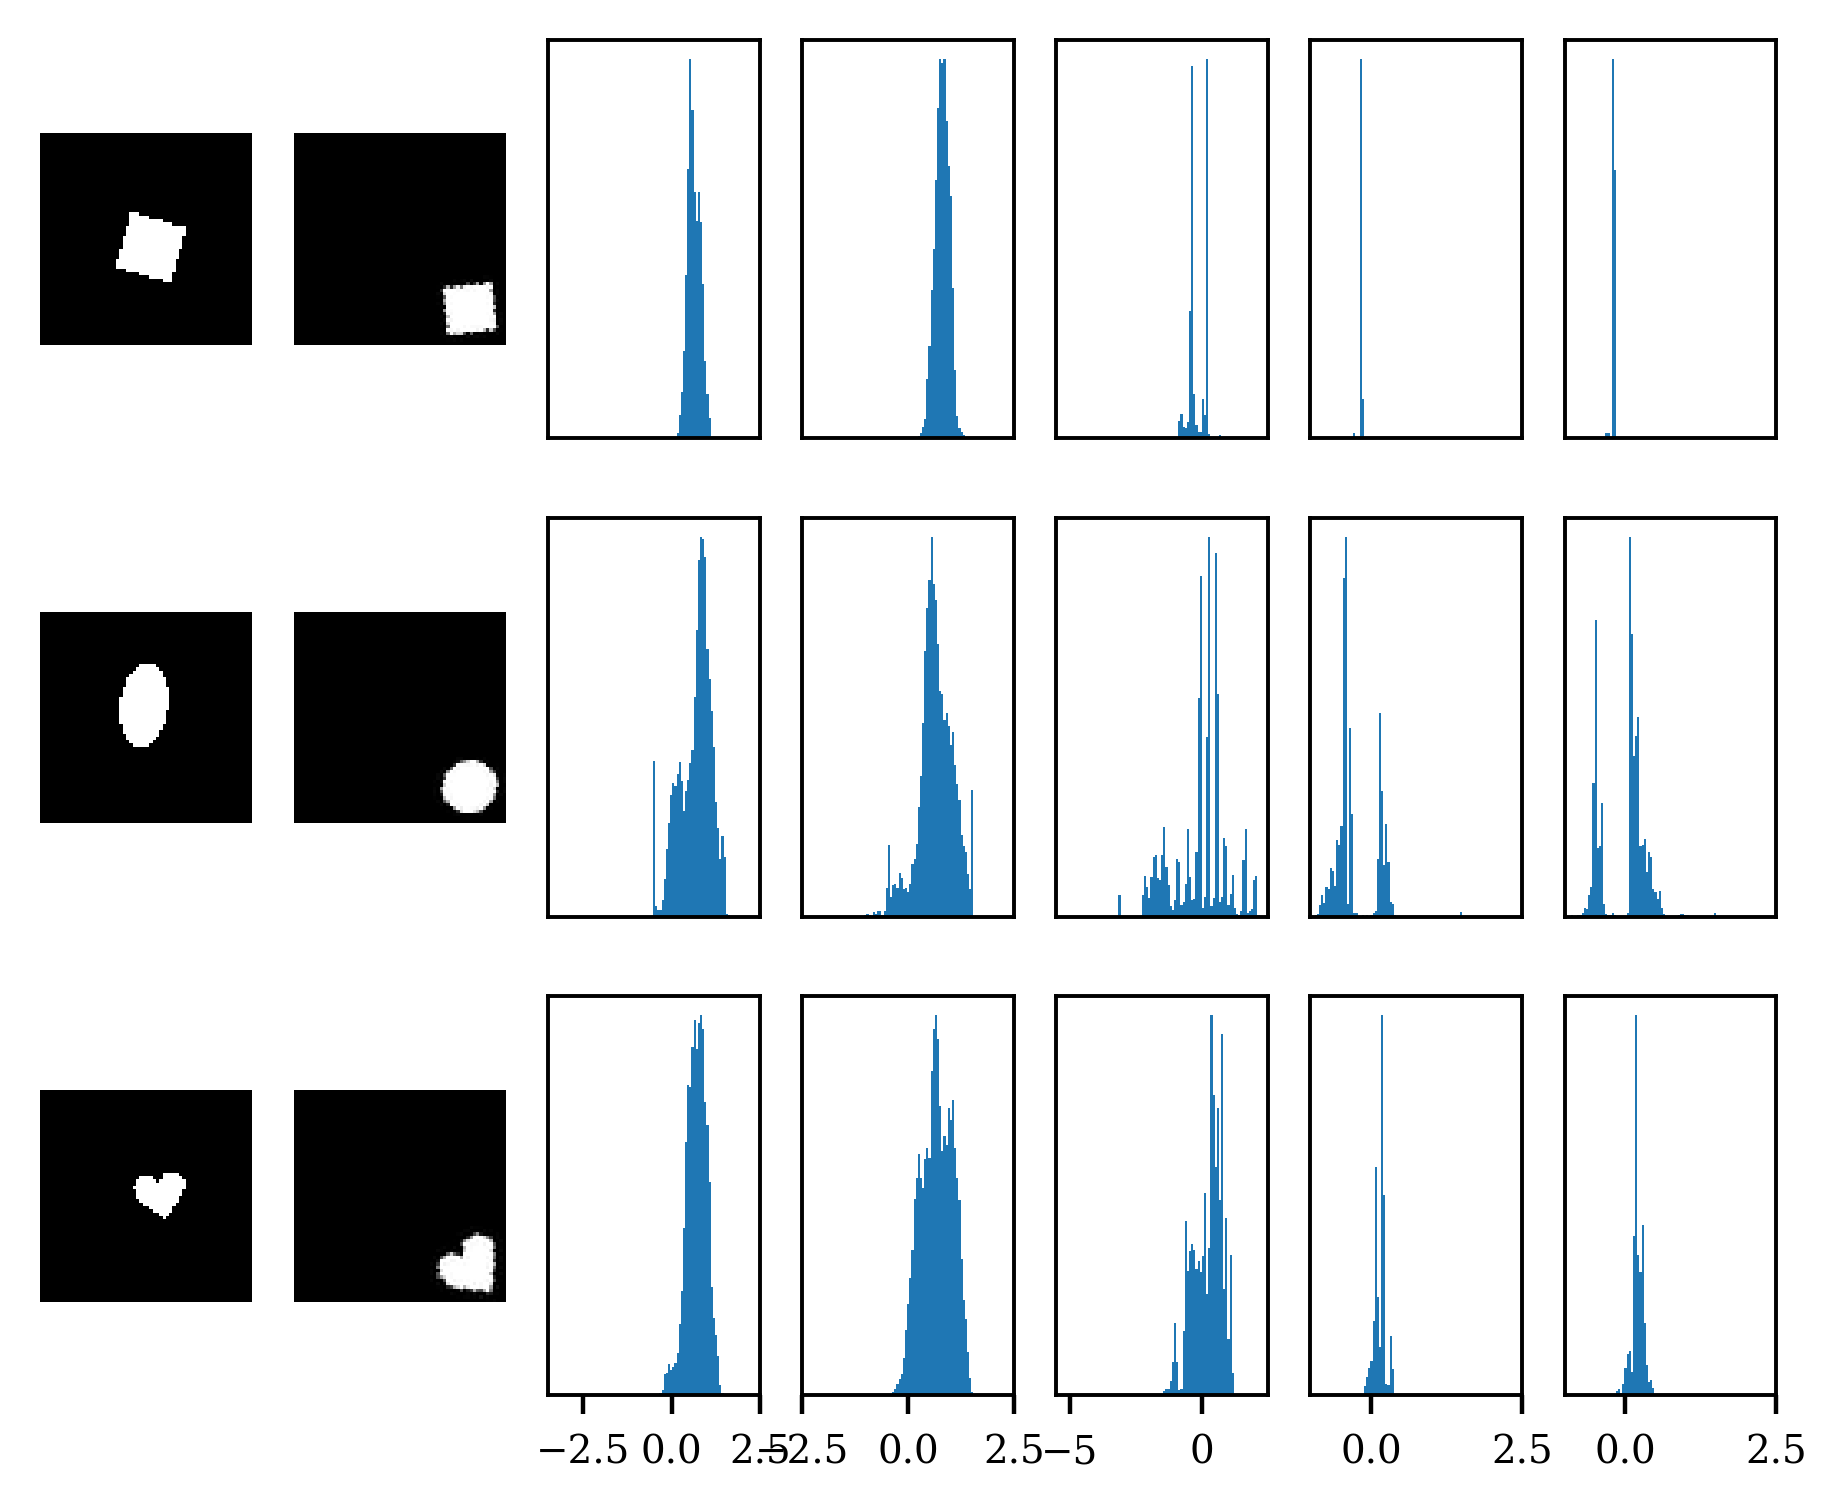

In [ ]:
grid_resolution = 2000
η_ranges = [
    (-3.5, 2.5),
    (-2.5, 2.5),
    (-5.5, 2.5),
    (-1., 2.5),
    (-1., 2.5),
]

rng_gen_samples, rng_proto, rng = random.split(rng, 3)

fig = plt.figure(dpi=400, figsize=(text_width,2 + 3 * text_width/7))
axes_all = fig.subplots(nrows=3, ncols=7, squeeze=True)

x = hearts_batch["image"][0]


for axes, x in zip(axes_all, [hearts_batch["image"][0], ellipses_batch["image"][0], squares_batch["image"][0]]):

    p_H_x_hat = gen_function(x, rng)
    # First get some samples to get a reasonable range for the plot:
    ηs_p = p_H_x_hat.sample(seed=rng_gen_samples, sample_shape=(10_000,))
    # Pick eta with highest probability:
    ηs_logprobs = jax.vmap(p_H_x_hat.log_prob)(ηs_p)
    η_base = ηs_p[jnp.argmax(ηs_logprobs)]

    axes[0].imshow(x, cmap="gray", vmin=-1.0, vmax=1.0)
    axes[1].imshow(prototype_function(x, rng_proto)[0], cmap="gray", vmin=-1.0, vmax=1.0)
    axes[0].axis(False)
    axes[1].axis(False)

    for i in range(5):
        # # Density
        # η_grid = np.linspace(*η_ranges[i], grid_resolution)
        # η = η_base[None, :].repeat(grid_resolution, axis=0)
        # η = η.at[:, i].set(η_grid)
        # probs = jnp.exp(jax.vmap(p_H_x_hat.log_prob)(η))
        # axes[i + 2].plot(η_grid, probs, color=c[0])
        # Histogram
        axes[i + 2].hist(ηs_p[:, i], bins=np.linspace(*η_ranges[i], 100), alpha=1.0, color=c[0])
        axes[i + 2].set_yticks([])
        axes[i + 2].set_xlim(*η_ranges[i])

# for i in range(5):
#     for j in [0, 1]:
#         axes_all[j, i + 2].sharex(axes_all[-1, i+2])

for i in range(5):
    for j in [0, 1]:
        axes_all[j, i + 2].xaxis.set_visible(False)

        
# # ηs_p = p_H_x_hat.sample(seed=rng_gen_samples, sample_shape=(20_000,))

# # transform_param_dim = p_H_x_hat.event_shape[0]
# # if fig is None:
# #     fig = plt.figure(figsize=(3*(transform_param_dim+2), 3))
# # axs = fig.subplots(nrows=1, ncols=transform_param_dim + 2)

# # axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
# # axs[0].axis('off')
# # axs[0].set_title("x")
# # axs[1].imshow(xhat, cmap='gray', vmin=-1, vmax=1)
# # axs[1].axis('off')
# # axs[1].set_title("x_hat")

# # for i, ax in enumerate(axs[2:]):
# #     x = np.linspace(ηs_p[:, i].min(), ηs_p[:, i].max(), 1000)

# #     # plot p(η|x_hat)
# #     ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
# #     kde = gaussian_kde(ηs_p[:, i])
# #     ax.plot(x, kde(x), color="C0")

# #     # make a axvline to plot η (the transformation inferred by transformation inference net.)
# #     ax.axvline(η[i], color="C1", linestyle="--")

# #     ax.set_title(f"dim {i}")
# #     ax.set_xlim(x.min(), x.max())

# # plt.tight_layout()
# # return fig

/tmp/ipykernel_3933334/3655436069.py:56: UserWarning: Log scale: values of z <= 0 have been masked
  cs = axes[0].contourf(


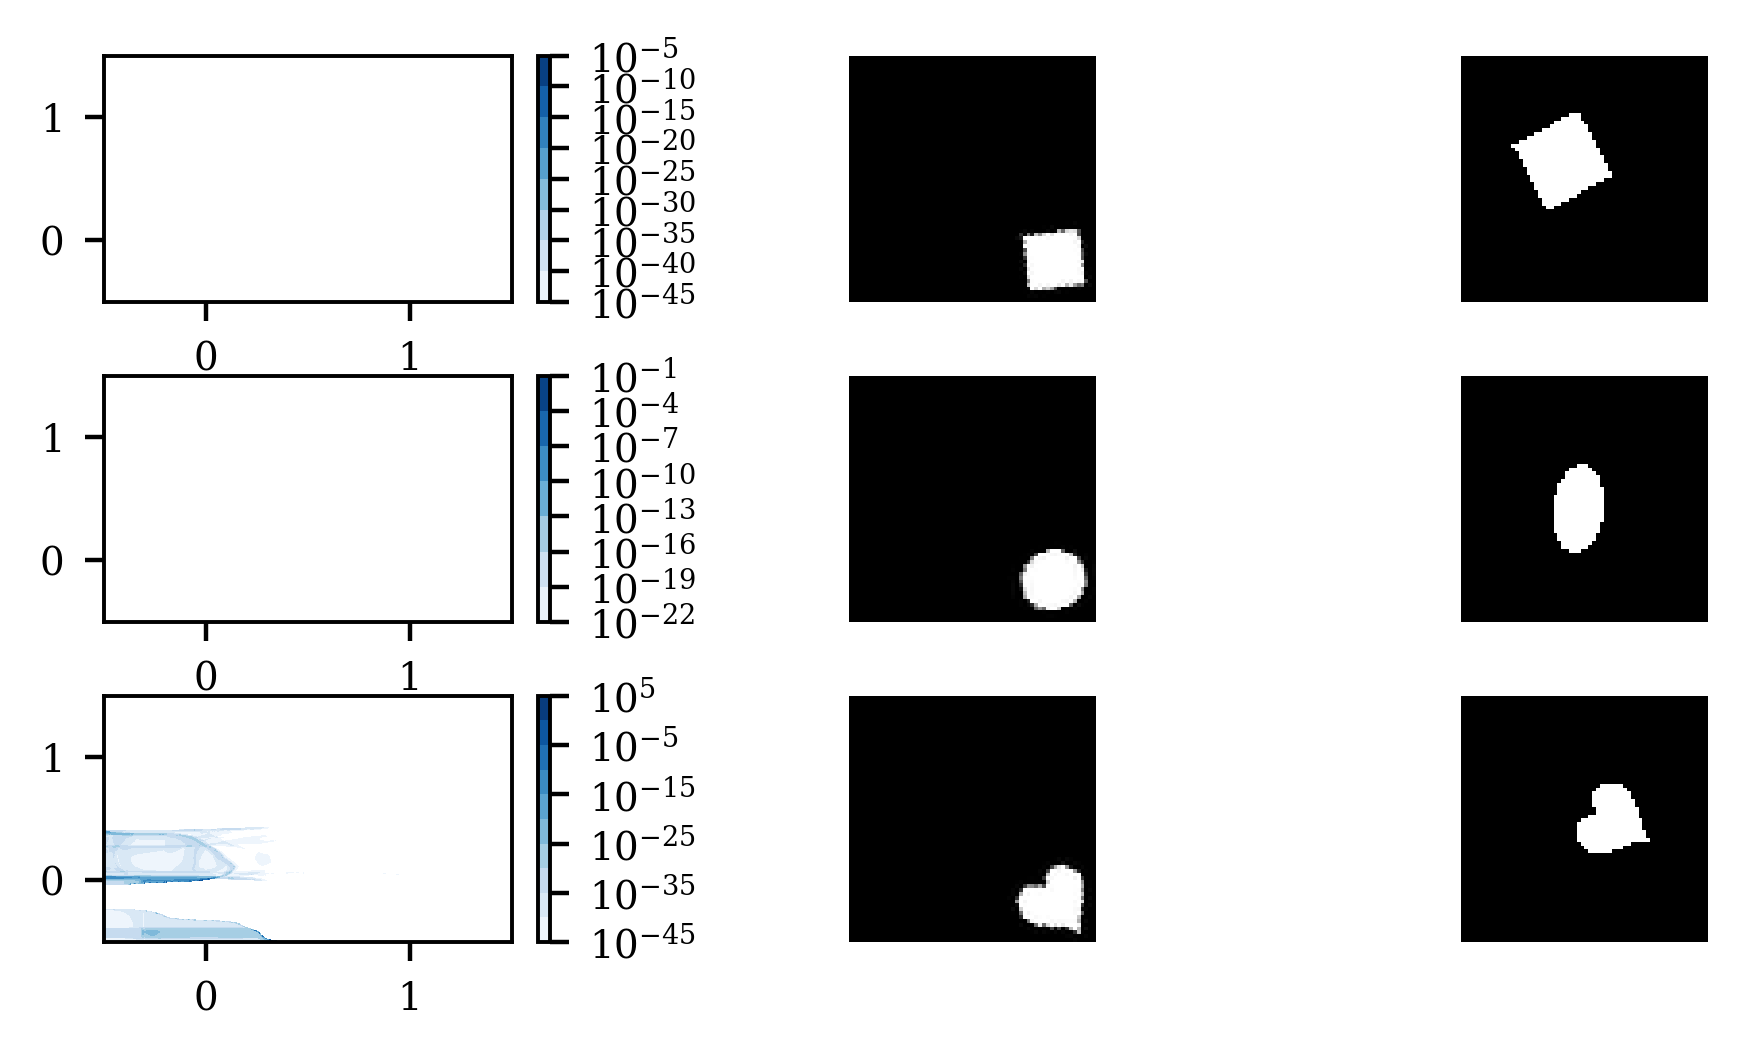

In [ ]:
heatmap_resolution = 800

rng_gen_samples, rng_proto, rng = random.split(rng, 3)

ncols = 7
fig = plt.figure(dpi=400, figsize=(text_width, 3 * text_width/ncols))
subfigs = fig.subfigures(nrows=3, ncols=1, squeeze=True)
for subfig, x in zip(subfigs, [hearts_batch["image"][1], ellipses_batch["image"][1], squares_batch["image"][1]]):
    axes = subfig.subplots(nrows=1, ncols=3, squeeze=True)

    # x = hearts_batch["image"][0]

    p_H_x_hat = gen_function(x, rng)
    # First get some samples to get a reasonable range for the plot:
    ηs_p = p_H_x_hat.sample(seed=rng_gen_samples, sample_shape=(10_000,))
    ηs_p_min = ηs_p.min(axis=-1)
    ηs_p_max = ηs_p.max(axis=-1)


    # Pick eta with highest probability:
    ηs_logprobs = jax.vmap(p_H_x_hat.log_prob)(ηs_p)
    η_base = ηs_p[jnp.argmax(ηs_logprobs)]

    axes[-1].imshow(x, cmap="gray", vmin=-1.0, vmax=1.0)
    axes[-2].imshow(prototype_function(x, rng_proto)[0], cmap="gray", vmin=-1.0, vmax=1.0)
    axes[-1].axis("off")
    axes[-2].axis(False)

    eta_x_trans = jnp.linspace(-0.5, 1.5, heatmap_resolution)
    eta_y_trans = jnp.linspace(-0.5, 1.5, heatmap_resolution)
    eta_rot = jnp.linspace(-3.0, 2.2, heatmap_resolution)
    eta_scale_x = jnp.linspace(-0.5, 1.5, heatmap_resolution)
    eta_scale_y = jnp.linspace(-0.5, 1.5, heatmap_resolution)

    # Scale against scale
    log_probs = jax.vmap(
        jax.vmap(
            lambda eta_1, eta_2: p_H_x_hat.log_prob(η_base.at[3].set(eta_1).at[4].set(eta_2)),
            in_axes=(0, None)
        ),
        in_axes=(None, 0)
    )(
        eta_scale_x,
        eta_scale_y,
    )
    probs = jnp.exp(log_probs)

    xx, yy = jnp.meshgrid(
        eta_x_trans, eta_y_trans
    )
    # eta_grid = ηs_p[87][None, :].repeat(heatmap_resolution**2, axis=0)
    # eta_grid = eta_grid.at[:, 0].set(xx.flatten())
    # eta_grid = eta_grid.at[:, 1].set(yy.flatten())
    # log_probs = jax.vmap(p_H_x_hat.log_prob)(eta_grid)
    # probs = jnp.exp(log_probs)
    probs_reshaped =  jnp.reshape(probs, [heatmap_resolution, heatmap_resolution])
    cs = axes[0].contourf(
        np.array(xx), np.array(yy), np.array(probs_reshaped), 
        # log ticks:
        locator=ticker.LogLocator(),
        cmap="Blues", levels=40)
    fig.colorbar(cs)

/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages

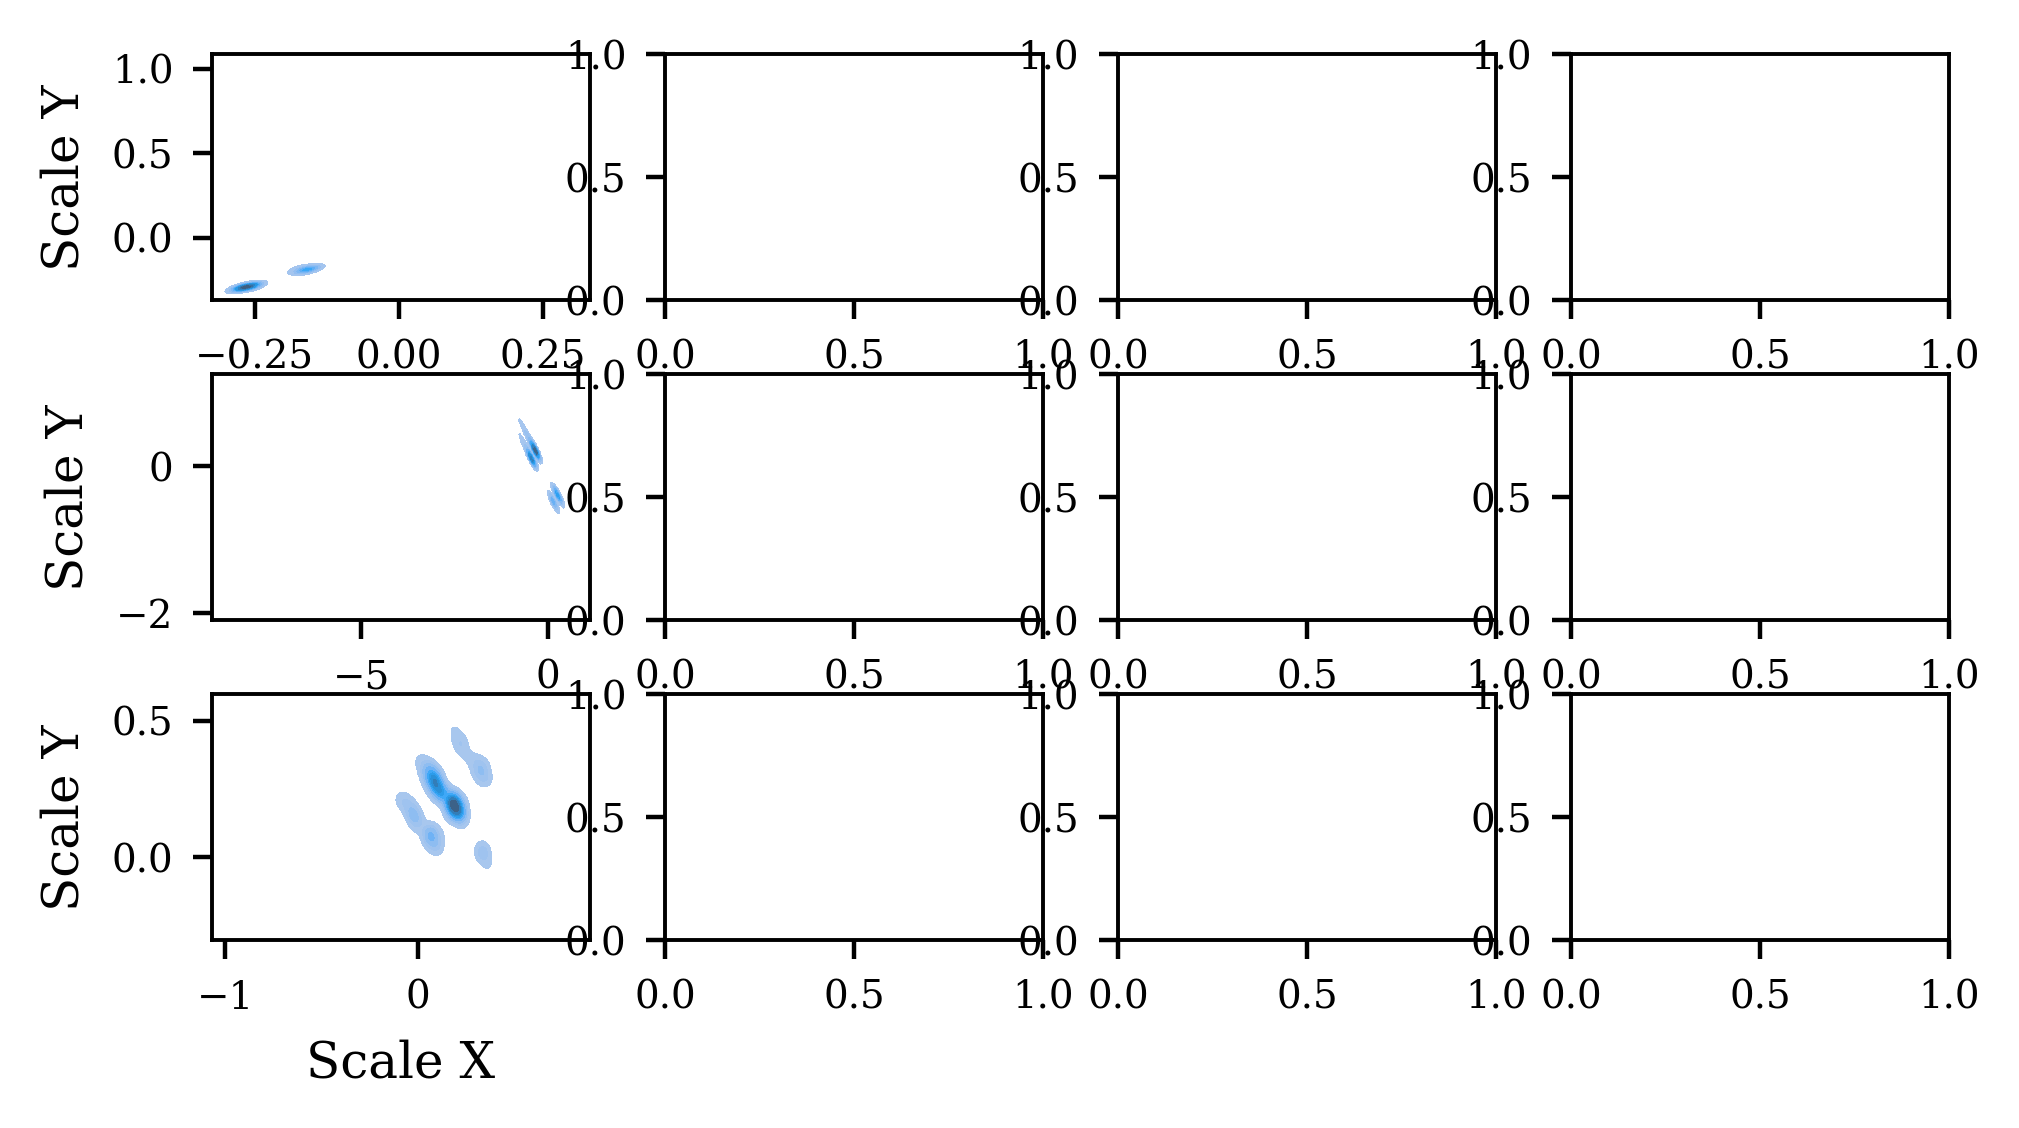

In [39]:
heatmap_resolution = 800
η_ranges = [
    (-3.5, 2.5),
    (-2.5, 2.5),
    (-5.5, 2.5),
    (-1., 2.5),
    (-1., 2.5),
]


rng_gen_samples, rng_proto, rng = random.split(rng, 3)

ncols = 7
fig = plt.figure(dpi=400, figsize=(text_width, 3 * text_width/ncols))
subfigs = fig.subfigures(nrows=3, ncols=1, squeeze=True)
for subfig, x in zip(subfigs, [hearts_batch["image"][1], ellipses_batch["image"][1], squares_batch["image"][1]]):
    axes = subfig.subplots(nrows=1, ncols=4, squeeze=True)

    p_H_x_hat = gen_function(x, rng)
    # First get some samples to get a reasonable range for the plot:
    ηs_p = p_H_x_hat.sample(seed=rng_gen_samples, sample_shape=(10_000,))
    # Filter out outliers
    ηs_p = ηs_p[jnp.all(jnp.abs(ηs_p) < 10, axis=1)]  
    ηs_p_min = ηs_p.min(axis=-1)
    ηs_p_max = ηs_p.max(axis=-1)

    sns.kdeplot(
        data=pd.DataFrame({
            "Scale X": ηs_p[:, 3],
            "Scale Y": ηs_p[:, 4],
        }
        ),
        x="Scale X",
        y="Scale Y",
        ax=axes[0],
        fill=True,
    )
    # axes[0].set_xlim(*η_ranges[3])
    # axes[0].set_ylim(*η_ranges[4])


/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_

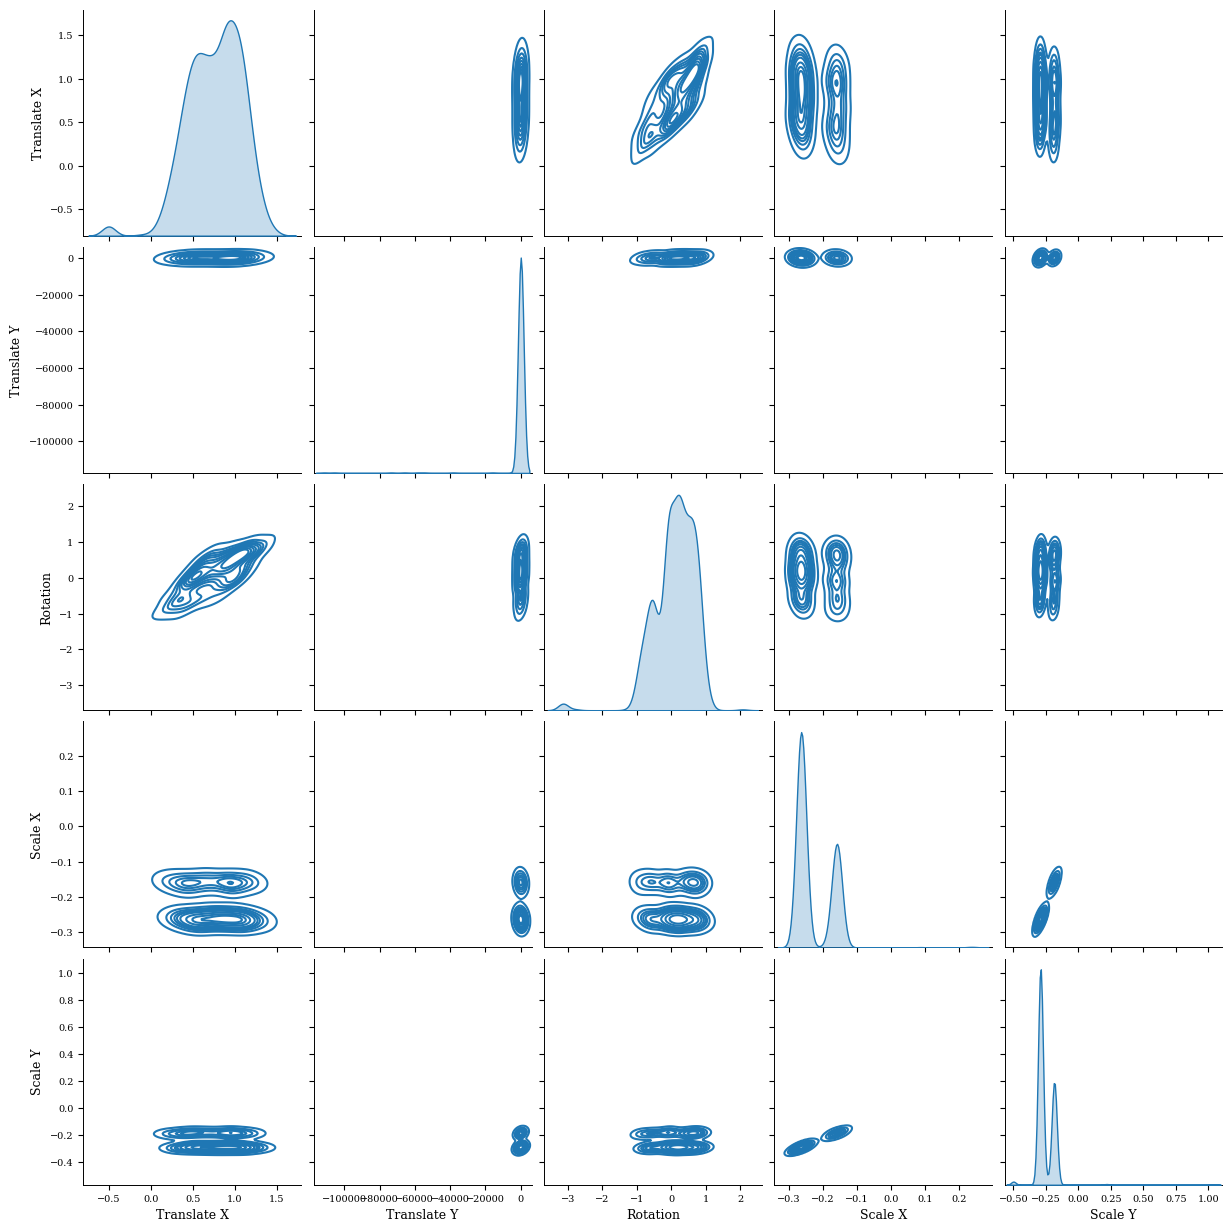

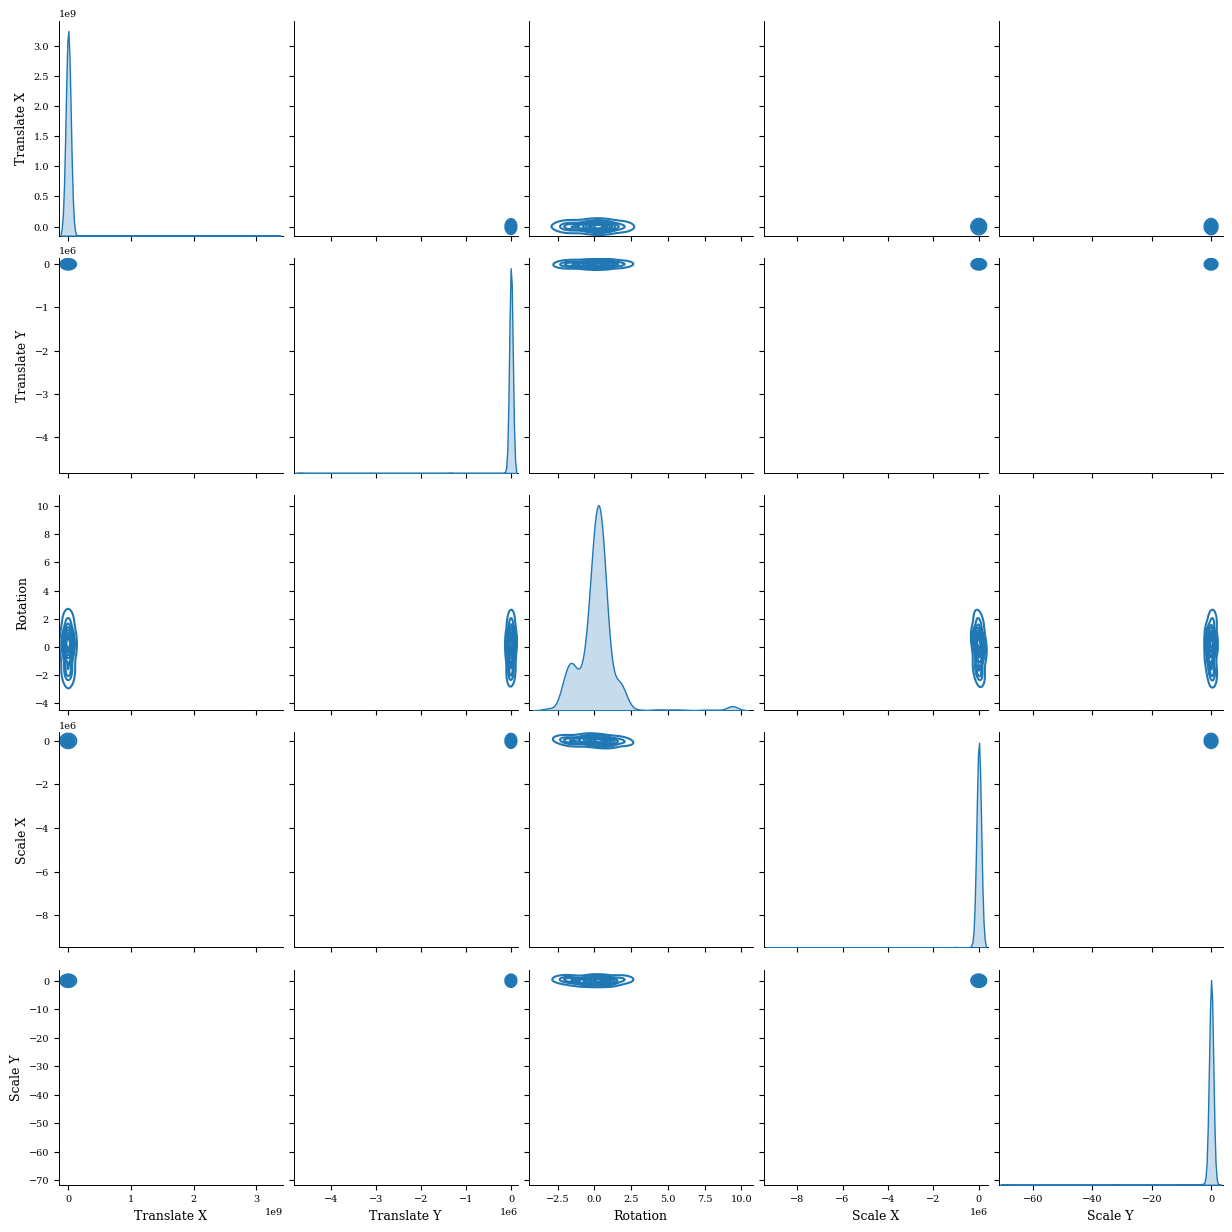

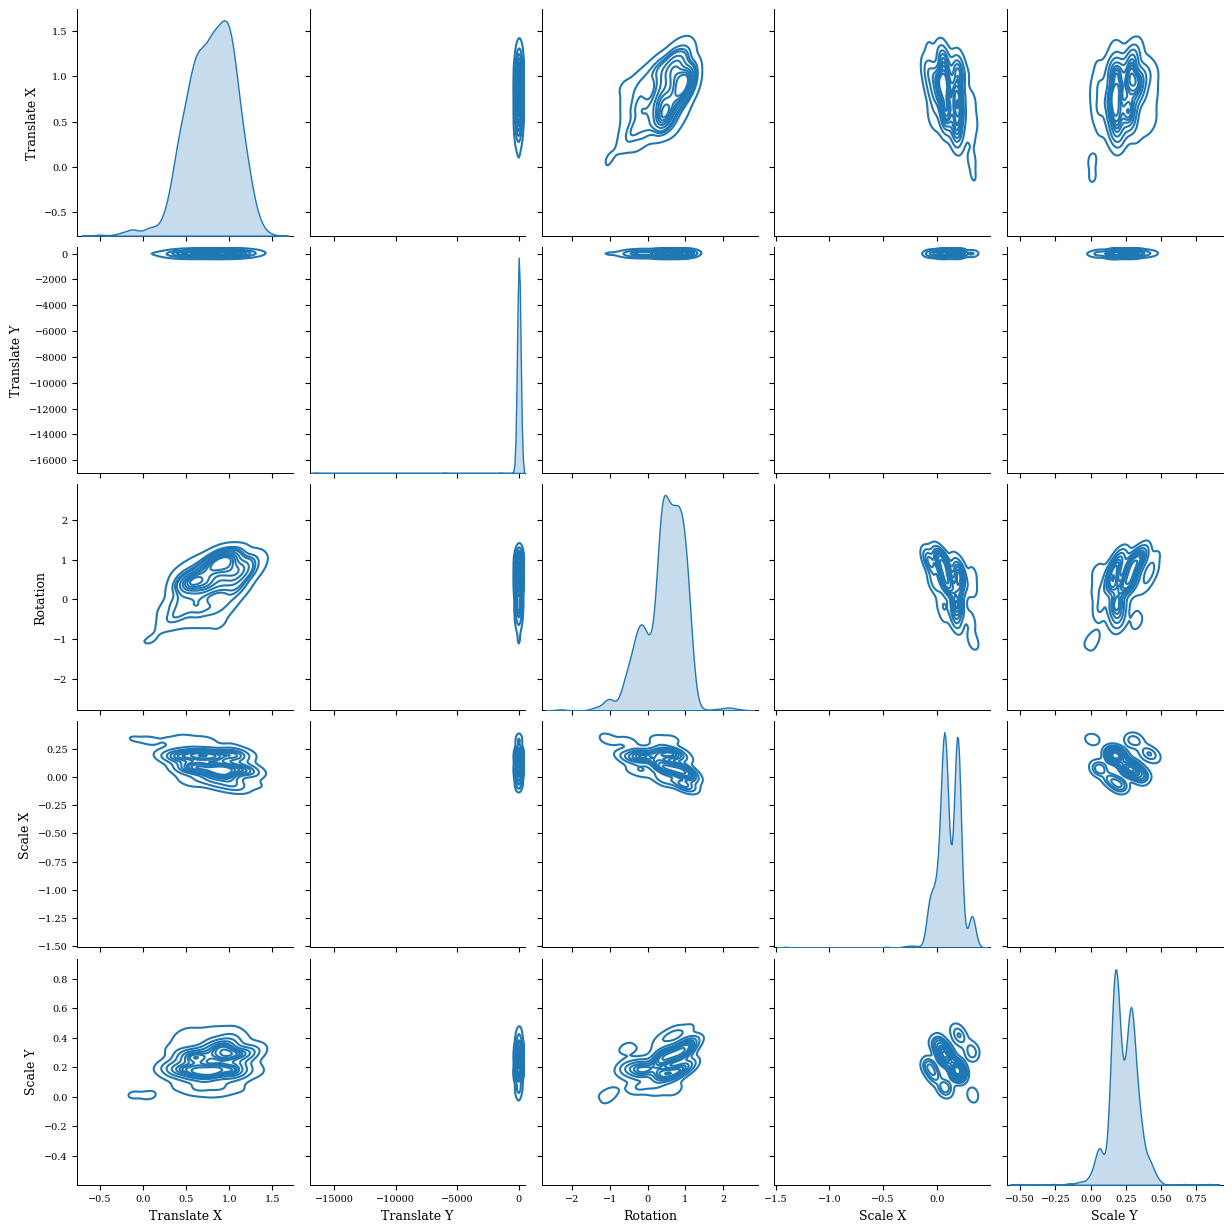

In [ ]:

rng_gen_samples, rng_proto, rng = random.split(rng, 3)

# fig = plt.figure(figsize=(text_width, 3 * text_width/4))
# subfigs = fig.subfigures(nrows=3, ncols=1, squeeze=True)
for x in [hearts_batch["image"][1], ellipses_batch["image"][1], squares_batch["image"][1]]:
    # axes = subfig.subplots(nrows=5, ncols=5, squeeze=True)

    # x = hearts_batch["image"][0]

    p_H_x_hat = gen_function(x, rng)
    # First get some samples to get a reasonable range for the plot:
    ηs_p = p_H_x_hat.sample(seed=rng_gen_samples, sample_shape=(1_000,))
    ηs_p = np.array(ηs_p)
    df=  pd.DataFrame({
        "Translate X": ηs_p[:, 0],
        "Translate Y": ηs_p[:, 1],
        "Rotation": ηs_p[:, 2],
        "Scale X": ηs_p[:, 3],
        "Scale Y": ηs_p[:, 4],
    })
    # break
    sns.pairplot(df, kind="kde", diag_kind="kde")

    # axes[-1].imshow(x, cmap="gray", vmin=-1.0, vmax=1.0)
    # axes[-2].imshow(prototype_function(x, rng_proto)[0], cmap="gray", vmin=-1.0, vmax=1.0)
    # axes[-1].axis("off")
    # axes[-2].axis(False)

    # axes[0]


/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/brunokm/.pyenv/versions/3.11.3/envs/jax-learning-inv/lib/python3.11/site-packages/seaborn/_

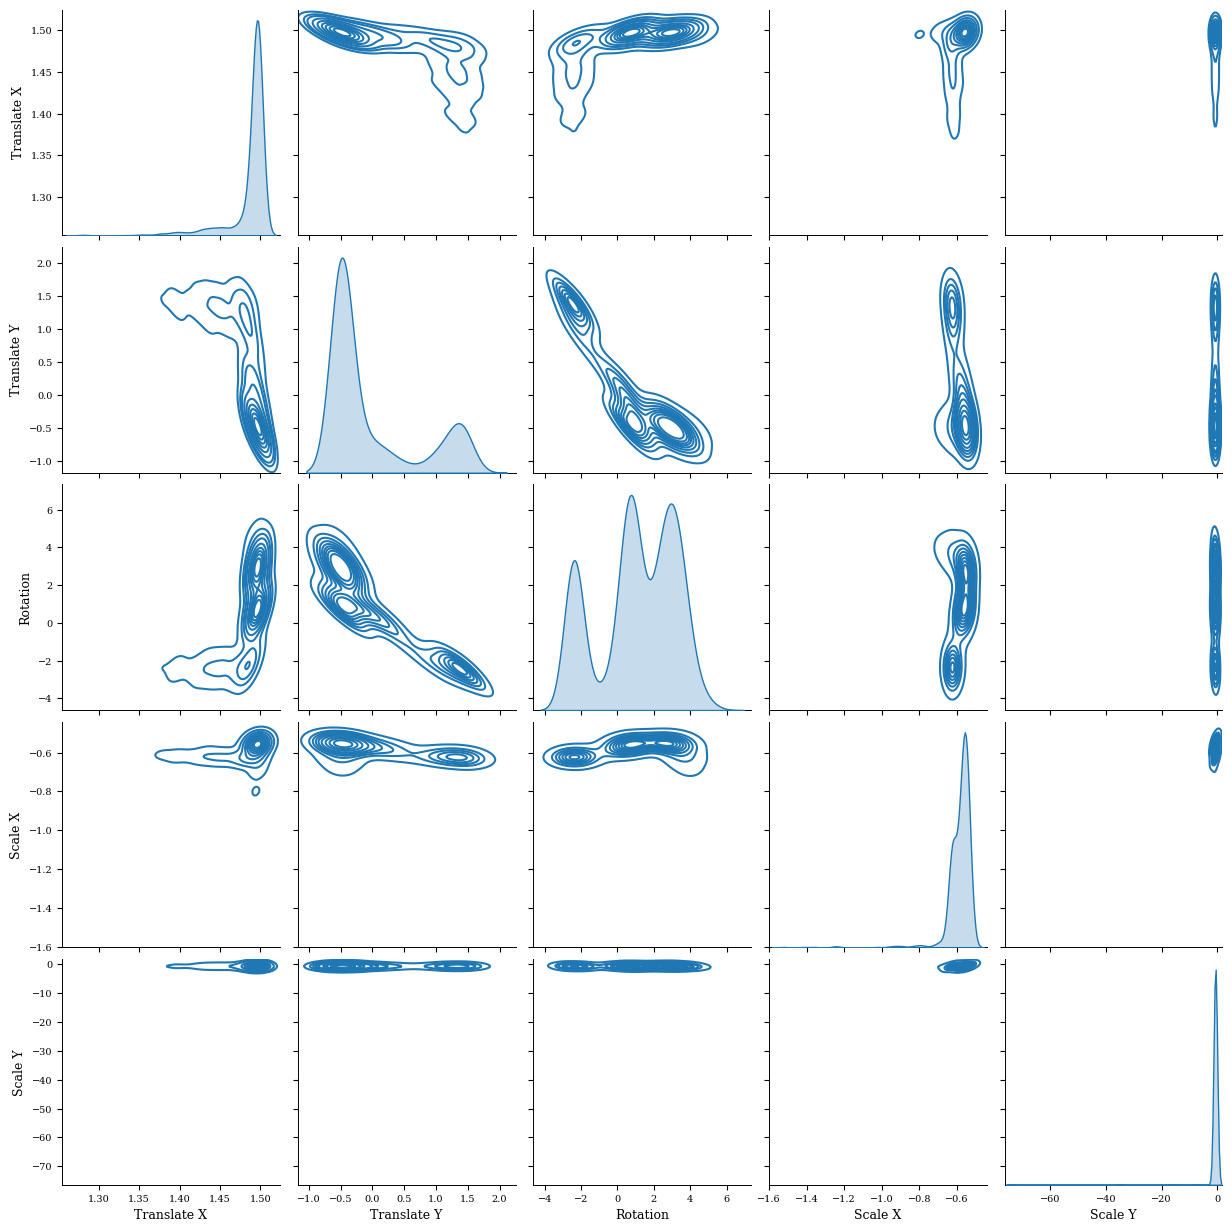

In [ ]:
sns.pairplot(data=df, diag_kind="kde", kind="kde")

##### Show it's the same for different x ()

(10000, 5)

### MNIST figures

In [26]:
# --------- Prototype model ----------
# --- fully rotated
# run: https://wandb.ai/invariance-learners/iclr2024experiments/runs/h6815ibd
proto_checkpoint_dir__full_rot = "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48"
# --- half rotated
proto_checkpoint_dir__half_rot = "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/20-33-59"
# --- no rotation
proto_checkpoint_dir__no_rot = "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/20-33-46"



# --------- Generative model ----------
# --- fully rotated 
# run: https://wandb.ai/invariance-learners/iclr2024experiments/runs/ixzb5wpo 
gen_checkpoint_dir__full_rot = "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/22-23-59"
# --- half rotated
# run: https://wandb.ai/invariance-learners/iclr2024experiments/runs/atrzesjf
gen_checkpoint_dir__half_rot = "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/22-23-12"
# --- no rotation
# run: https://wandb.ai/invariance-learners/iclr2024experiments/runs/1s1lvcc6
gen_checkpoint_dir__no_rot = "/home/brunokm/projects/learning-invariances/outputs/2023-10-16/22-23-43"



In [27]:
# Get some validation data:
proto_config, *_ = get_config_state(proto_checkpoint_dir__full_rot)
rng, data_rng = random.split(rng)
_, val_ds, _ = get_data(proto_config, data_rng)
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/state.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/state.
INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/config.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/config.
INFO:absl:Load dataset info from /home/brunokm/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/brunokm/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /home/brunokm/tensorflow_datas

INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /home/brunokm/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28

In [28]:
def add_outline_to_img(img, outline_color, outline_thickness):
    # Jax function for adding an outline to an image

    img_shrunk = img[outline_thickness:-outline_thickness, outline_thickness:-outline_thickness, :]
    # Add outline to image
    out = jax.vmap(
        lambda im, color: jnp.pad(
            im,
            pad_width=outline_thickness,
            mode="constant",
            constant_values=color,
        ),
        in_axes=(-1, 0),
        out_axes=-1,
    )(img_shrunk, outline_color)
    return out

def add_outline_to_onechannel_img(img, outline_color, outline_thickness):
    return add_outline_to_img(
        img=jnp.concatenate([img, img, img], axis=-1),
        outline_color=outline_color,
        outline_thickness=outline_thickness,
    )


In [29]:
def prototype_transform_function(x, rng, model, state):
    η = model.apply({"params": state["params"]}, x, train=False).sample(
        seed=rng
    )
    return η

def prototype_function(x, rng, model, state):
    η = prototype_transform_function(x, rng, model, state)
    η_aff_mat = gen_affine_matrix_no_shear(η)
    η_aff_mat_inv = jnp.linalg.inv(η_aff_mat)
    xhat = transform_image_with_affine_matrix(x, η_aff_mat_inv, order=proto_config.interpolation_order)
    return xhat, η


def gen_function(x, rng, proto_model, proto_state, gen_model, gen_state):
    xhat, _ = prototype_function(x, rng, proto_model, proto_state)
    p_H_xhat, _ = gen_model.apply({"params": gen_state["params"]}, xhat, η=jnp.zeros((5,)), train=False)
    return p_H_xhat

INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/state.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/state.
INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/config.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/19-38-48/checkpoints/20001/config.
INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/20-33-46/checkpoints/20001/state.
INFO:absl:Finished restoring checkpoint from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/20-33-46/checkpoints/20001/state.
INFO:absl:Restoring item from /home/brunokm/projects/learning-invariances/outputs/2023-10-16/20-33-46/checkpoints/20001/config.
INFO:absl:Finished restoring checkpoint from /home/brunokm/proj

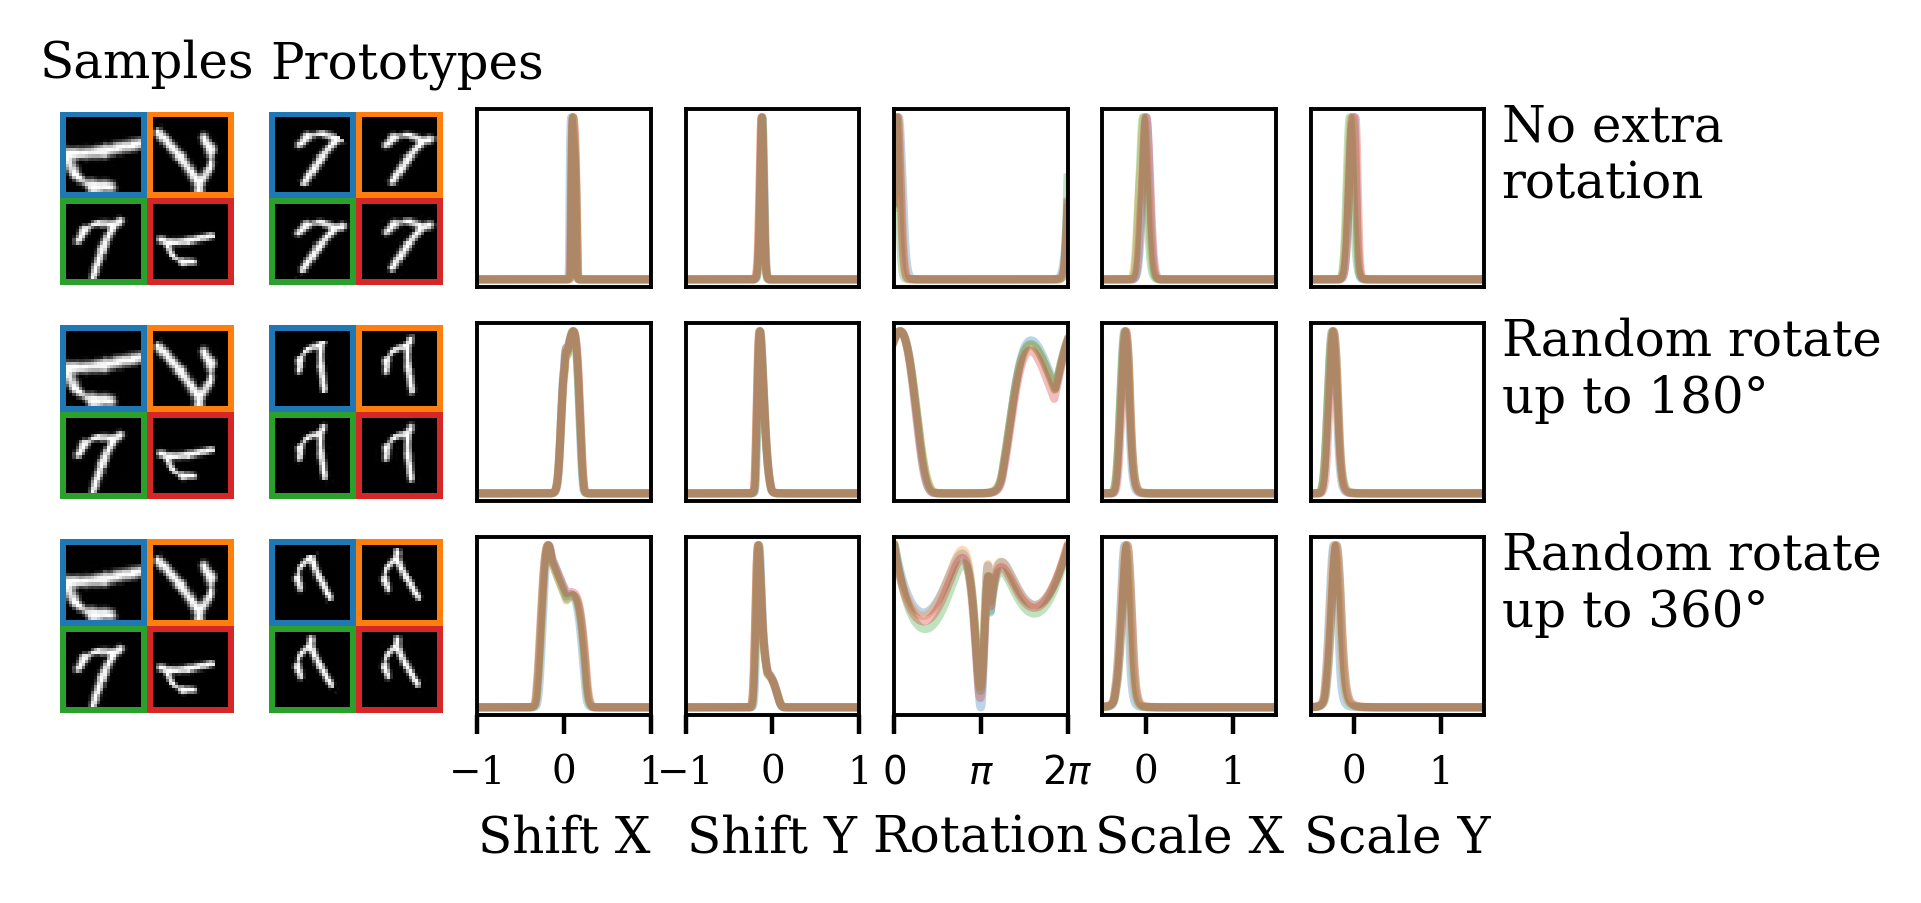

In [69]:
import math


grid_resolution = 2000
outline_thickness = 2

num_prototypes = 2 ** 2
img_grid_size = int(np.sqrt(num_prototypes))

colors = sns.color_palette("tab10", num_prototypes)

η_ranges = [
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-0., 2 * math.pi),
    (-0.5, 1.5),
    (-0.5, 1.5),
]

rng_gen_samples, rng_proto, rng = random.split(rng, 3)

fig_width = text_width *0.82
fig = plt.figure(dpi=400, figsize=(fig_width, 3 * fig_width/7))
axes_all = fig.subplots(nrows=3, ncols=7, squeeze=True)

x = val_batch["image"][0, 16]
# Get some transformed variants of x
proto_config, _ = get_config_state(proto_checkpoint_dir__full_rot)
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x,
    jnp.concatenate(
        (
            jnp.linspace(
                -jnp.array(proto_config.eval_augment_bounds),
                jnp.array(proto_config.eval_augment_bounds),
                num_prototypes,
            ),
        )
    ),
)

for axes, proto_checkpoint_dir, gen_checkpoint_dir, title in zip(
    axes_all,
    [proto_checkpoint_dir__no_rot, proto_checkpoint_dir__half_rot, proto_checkpoint_dir__full_rot],
    [gen_checkpoint_dir__no_rot, gen_checkpoint_dir__half_rot, gen_checkpoint_dir__full_rot],
    ["No extra\nrotation", "Random rotate\nup to 180°", "Random rotate\nup to 360°"],
):
    # Load the prototype model
    proto_config, proto_state = get_config_state(proto_checkpoint_dir)
    proto_model = TransformationInferenceNet(
        bounds=proto_config.get("augment_bounds", None),
        offset=proto_config.get("augment_offset", None),
        **proto_config.model.inference
    )
    # Load the gen model
    gen_config, gen_state = get_config_state(gen_checkpoint_dir)
    gen_model = TransformationGenerativeNet(
        bounds=gen_config.get("augment_bounds", None),
        offset=gen_config.get("augment_offset", None),
        **gen_config.model.generative
    )

    assert gen_config.prototype_model_dir == proto_checkpoint_dir

    # Get the prototypes:
    prototypes = jax.vmap(
        lambda x: prototype_function(x, rng_proto, proto_model, proto_state)[0],
        in_axes=(0),
    )(transformed_xs)

    # ---
    # Add outlines to xs and prototypes:
    xs_with_outline = jax.vmap(
        lambda x, color: add_outline_to_onechannel_img(x, outline_color=color, outline_thickness=outline_thickness),
        in_axes=(0, 0),
    )((transformed_xs + 1) / 2, jnp.array(colors))
    prototypes_with_outline = jax.vmap(
        lambda x, color: add_outline_to_onechannel_img(x, outline_color=color, outline_thickness=outline_thickness),
        in_axes=(0, 0),
    )((prototypes + 1) / 2, jnp.array(colors))

    xs_grid = put_images_in_grid(xs_with_outline, img_grid_size)
    prototypes_grid = put_images_in_grid(prototypes_with_outline, img_grid_size)
    axes[0].imshow(xs_grid, vmin=0., vmax=1.0)
    axes[1].imshow(prototypes_grid, vmin=0., vmax=1.0)
    axes[0].axis(False)
    axes[1].axis(False)
    for j in range(num_prototypes):

        p_H_x_hat, _ = gen_model.apply({"params": gen_state["params"]}, prototypes[j], train=False)
        η_base = jnp.zeros((grid_resolution, 5))
        for i in range(5):
            η_grid = np.linspace(*η_ranges[i], grid_resolution)

            η = η_base.at[:, i].set(η_grid)
            probs = jnp.exp(p_H_x_hat.log_prob(η))
            if i == 2:  # i rotation, sum over multiple periodic spans

                for k in [-3, -2, -1, 1, 2, 3]:
                    η_grid_shifted = η_grid + k * 2 * math.pi
                    η = η_base.at[:, i].set(η_grid_shifted)
                    probs = jnp.exp(p_H_x_hat.log_prob(η)) + probs
                    # set ax ticks
                    axes[i + 2].set_xticks(
                        [0, math.pi, math.pi*2],
                        ["$0$", "$\pi$", "$2\pi$"],
                    )
            axes[i + 2].plot(η_grid, probs / probs.max(), color=colors[j], alpha=0.3)
            axes[i + 2].set_yticks([])
            axes[i + 2].set_xlim(*η_ranges[i])
    axes[-1].set_title(title, y=0.25, x=1.1, horizontalalignment="left", verticalalignment="bottom")


for i in range(5):
    for j in [0, 1]:
        axes_all[j, i + 2].xaxis.set_visible(False)

axes_all[-1, 2].set_xlabel("Shift X")
axes_all[-1, 3].set_xlabel("Shift Y")
axes_all[-1, 4].set_xlabel("Rotation")
axes_all[-1, 5].set_xlabel("Scale X")
axes_all[-1, 6].set_xlabel("Scale Y")
axes_all[0, 0].set_title("Samples")
axes_all[0, 1].set_title("Prototypes", x=0.01, horizontalalignment="left")


fig.savefig("figures/mnist_learnt_distributions.pdf", bbox_inches="tight")

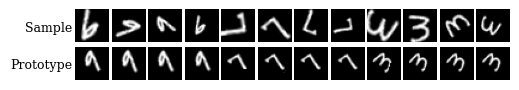

In [79]:
num_images_per_example = 4
fig = plt.figure(figsize=(text_width, 2 * text_width / (3 * num_images_per_shape)))
axes = fig.subplots(nrows=2, ncols= 3 * num_images_per_shape, squeeze=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)


images = [ x
for j in range(3)
          for x in jax.vmap(transform_image, in_axes=(None, 0))(
        val_batch["image"][0, j + 148],
        jnp.concatenate(
            (
                jnp.linspace(
                    -jnp.array(proto_config.eval_augment_bounds),
                    jnp.array(proto_config.eval_augment_bounds),
                    num_images_per_example,
                ),
            )
        ),
    )
]
for i, image in enumerate(images):
    axes[0, i].imshow(image, cmap="gray", vmin=-1.0, vmax=1.0)
    axes[0, i].axis("off")
    axes[1, i].imshow(prototype_function(image, rng, proto_model, proto_state)[0], cmap="gray", vmin=-1.0, vmax=1.0)
    axes[1, i].axis("off")
axes[0, 0].set_title('Sample', y=0.0, x=-0.1, horizontalalignment="right", verticalalignment="bottom")
axes[1, 0].set_title('Prototype', y=0.0, x=-0.1, horizontalalignment="right", verticalalignment="bottom")

fig.savefig("figures/mnist_prototype_reconstruction.pdf", bbox_inches="tight")
